# Init

In [13]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%autoreload 2
from src.MapData import MapData
from src.LineFinder import LineFinder

from src.plotting_functions import plot_embedding, plot_single_variable_map

In [34]:
map_data = MapData('./data/2022_03_22_P56B_307x532.libsdata')
map_data.get_metadata()
map_data.load_wavelenths()
map_data.load_all_data()
map_data.get_map_dimensions()
map_data.trim_spectra(64)

maxima_spectrum = map_data.spectra.max(axis=0)

line_finder = LineFinder(
    maxima_spectrum,
    map_data.wvl,
    name='maxima'
)
line_finder.find_lines(
    height=250,
    threshold=None,
    distance=None,
    prominence=200,
    width=3,
    wlen=27,
    rel_height=1.2,
)
line_finder.load_nist_tables(
    Path('C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum, 
    scale=False,
    show_cond=False
)

map_data.get_baseline(50,100)
map_data.baseline_correct()

map_data.get_emission_line_intensities(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0],
    intensity_func=np.max
)

creating base plot


In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

embeddings = dict()

In [38]:
pca_model = PCA(3)
embeddings['pca'] = pca_model.fit_transform(
    pd.DataFrame(map_data.line_intensities)
)

tsne_model = TSNE(
    n_components=3,
    perplexity=30, 
    learning_rate=200
)
embeddings['tsne'] = tsne_model.fit_transform(
    pd.DataFrame(map_data.line_intensities)
)

umap_model = UMAP(n_components=3, n_neighbors=30, min_dist=0.5)
embeddings['umap'] = umap_model.fit_transform(
    pd.DataFrame(map_data.line_intensities)
)

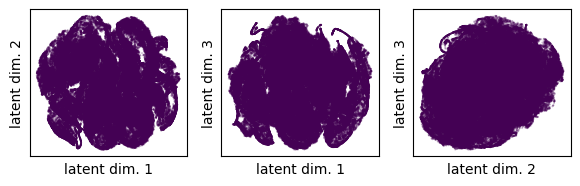

In [43]:
embedding_method = 'tsne'

fig = plot_embedding(
    embeddings[embedding_method],
    # explained_variances=pca_model.explained_variance_ratio_.copy(),
    # colors=predicted_labels[clustering_method],
    marker_size=2,
    return_figure=True
)
# fig.suptitle(clustering_method)
fig.patch.set_alpha(0)
fig.tight_layout()
# fig.savefig(
#     f'./temp/{embedding_method}_embeddings_full_spectra_clustering_using_{clustering_method}_{segment}',
#     transparent=True
# )

In [47]:
%pwd

'c:\\Users\\kepes\\Projects\\segmentation'

In [49]:
from joblib import dump

dump(pca_model, './temp/pca_model.joblib')
dump(tsne_model, './temp/tsne_model.joblib')
dump(umap_model, './temp/umap_model.joblib')

['./temp/umap_model.joblib']

In [ ]:
from joblib import load
rf_loaded = load('rf_model.joblib')

In [51]:
np.save(file='./temp/embeddings_pca.npy', arr=embeddings['pca'])
np.save(file='./temp/embeddings_tsne.npy', arr=embeddings['tsne'])
np.save(file='./temp/embeddings_umap.npy', arr=embeddings['umap'])